In [54]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
from torch.autograd import Variable
import math
import numpy as npP
from natsort import natsorted
from PIL import Image
import random
import pickle

In [55]:
# Code to upload dataset to google colab

from google.colab import drive
drive.mount('/content/drive')

import zipfile

path_to_zip_file = 'drive/MyDrive/data.zip'
directory_to_extract_to = 'VISCHEMA_PLUS/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

!cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
!cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"

ModuleNotFoundError: No module named 'google'

In [56]:
# Create datasets and dataloaders

import pandas as pd

class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

image_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(0.5,0.5)
])

batch_size = 8

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

4 Items in Train dataset
4  Items in Validation dataset


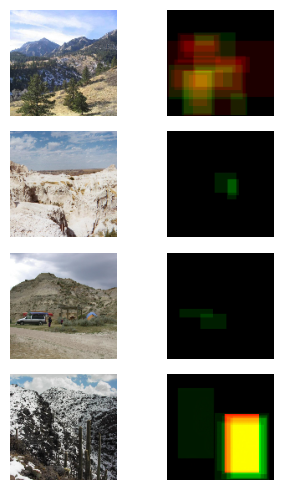

In [57]:
# Examine some image label pairs

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [58]:
# Generator Model

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, norm = True, norm_func = nn.InstanceNorm2d):
        super().__init__()
        if norm:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
        else:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm = (i != 0), norm_func = norm_func) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(512,256,128,64), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm_func = norm_func) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class Generator(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512,1024), 
                 decode_channels=(1024,512,256,128,64), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572),
                 norm_func = nn.InstanceNorm2d):
        
        super(Generator, self).__init__()
        
        self.encoder = Encoder(encode_channels, norm_func = norm_func)
        self.decoder = Decoder(decode_channels, norm_func = norm_func)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""

    def forward(self, x):
        
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)
        output = nn.Tanh()(output)
        
        return output

model = Generator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet Generator')

images, _ = next(iter(train_loader))
output = model(images)

print(output.shape)

del model, output, images

31031875 Parameters in UNet Generator
torch.Size([4, 3, 128, 128])


In [59]:
# Discriminator Model

class Discriminator(nn.Module):
    def __init__(self, norm_func = nn.BatchNorm2d, channels = (6,64,128,256,512,1024)):
        super(Discriminator, self).__init__()

        def Block(in_channels, out_channels, norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4,stride=2, padding=1)]
            if norm:
                layers.append(norm_func(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *Block(channels[0],channels[1], norm = False),
            *Block(channels[1],channels[2]),
            *Block(channels[2],channels[3]),
            *Block(channels[3],channels[4]),
            *Block(channels[4],channels[5]),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(channels[5],1,4,padding=1, bias=False),
        )

    def forward(self, images, labels):
        image_input = torch.cat((images, labels), 1)
        return self.model(image_input)

model = Discriminator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in Discriminator')

images, labels = next(iter(train_loader))
output = model(images, labels)
print(output.shape)

del model, output, images

11169472 Parameters in Discriminator
torch.Size([4, 1, 4, 4])


In [60]:
t = torch.zeros((1024, 4, 4))
print(t.shape)
t = torch.flatten(t)
print(t.shape)

torch.Size([1024, 4, 4])
torch.Size([16384])


In [73]:
def train_GAN(
    generator, 
    discriminator,
    optim_g,
    optim_d,
    save_dir,
    criterion_GAN = nn.MSELoss(),
    criterion_pixelwise = nn.L1Loss()
    ):

    ###################################
    # Set up our training environment #
    ###################################

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator, discriminator = generator.to(device), discriminator.to(device)

    patch = (1, 4, 4)

    train_losses = []
    val_losses = []
    best_val_loss = 1000000

    # Loss weight of L1 pixel-wise loss between translated image and real image
    # This value is copied from the PIX2PIX architecture
    lambda_pixel = 100
    num_epochs = 300
    
    #######################
    # Start Training Loop #
    #######################

    print(f'Starting Training for {save_dir}')
    for epoch in range(num_epochs):

        # Go into training mode
        discriminator.train()
        generator.train()

        # Train the model and evaluate on the training set
        total_train_loss = 0
        total_val_loss = 0

        for i, (images, real_labels) in enumerate(train_loader):

            # Adversarial ground truths
            valid = torch.ones((images.size(0), *patch)).to(device)
            fake = torch.zeros((images.size(0), *patch)).to(device)

            # Move images to device and create an image prediction
            images, real_labels = images.to(device), real_labels.to(device)

            ###################
            # Train Generator #
            ###################

            optim_g.zero_grad()

            # GAN Loss

            fake_labels = generator(images)
            pred_fake = discriminator(fake_labels, images)
            loss_GAN = criterion_GAN(pred_fake, valid)
            loss_pixel = criterion_pixelwise(fake_labels, real_labels)

            # Logging
            batch_loss = loss_pixel.item() * batch_size
            total_train_loss += batch_loss

            loss_G = loss_GAN + lambda_pixel * loss_pixel

            loss_G.backward()
            optim_g.step()

            #######################
            # Train Discriminator #
            #######################

            optim_d.zero_grad()

            # Real Loss
            pred_real = discriminator(real_labels, images)
            loss_real = criterion_GAN(pred_real, valid)

            # Fake Loss
            pred_fake = discriminator(fake_labels.detach(), images)
            loss_fake = criterion_GAN(pred_fake, fake)

            # Total Loss
            loss_D = 0.5 * (loss_real + loss_fake)

            loss_D.backward()
            optim_d.step()

            # Clear memory
            del images, real_labels, fake_labels 
            torch.cuda.empty_cache() 

        generator.eval()
        with torch.no_grad():
          for i, (images, real_labels) in enumerate(val_loader):

              # Adversarial ground truths
              valid = torch.ones((images.size(0), *patch)).to(device)
              fake = torch.zeros((images.size(0), *patch)).to(device)

              # Move images to device and create an image prediction
              images, real_labels = images.to(device), real_labels.to(device)

              #########################
              # Test Generator On Val #
              #########################

              # GAN Loss

              fake_labels = generator(images)
              loss_pixel = criterion_pixelwise(fake_labels, real_labels)
              batch_loss = loss_pixel.item() * batch_size
              total_val_loss += batch_loss

              # Clear memory
              del images, real_labels, fake_labels 
              torch.cuda.empty_cache() 

        train_losses.append( total_train_loss/ len(train_loader))
        val_losses.append( total_val_loss / len(val_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], D: {loss_D.item():.4f}, G: {loss_G.item():.4f},  Val Loss: {val_losses[-1]} Train Loss: {train_losses[-1]}')

    print(f"Graph for {save_dir}")
    plt.plot(range(len(train_losses)),train_losses,'r', label='Training Losses')
    plt.plot(range(len(val_losses)),val_losses,'g', label='Validation Losses')
    plt.legend(loc = "upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Examine some image label pairs
    images = [val_dataset.__getitem__(0)[0],val_dataset.__getitem__(1)[0],val_dataset.__getitem__(2)[0],val_dataset.__getitem__(3)[0]]
    labels = [val_dataset.__getitem__(0)[1],val_dataset.__getitem__(1)[1],val_dataset.__getitem__(2)[1],val_dataset.__getitem__(3)[1]]
    output = [generator(torch.unsqueeze(image, dim=0)) for image in images]

    figure = plt.figure(figsize=(5,5))
    cols, rows = 3, 4
    for i in range(rows):
        # The image
        figure.add_subplot(rows,cols, cols*i+1)
        plt.axis("off")
        plt.imshow((images[i].squeeze().permute(1, 2, 0) +1 )/2 )
        # The Label
        figure.add_subplot(rows,cols, cols*i+2)
        plt.axis("off")
        plt.imshow((labels[i].squeeze().permute(1, 2, 0) +1 )/2)
        # The Output
        figure.add_subplot(rows,cols, cols*i+3)
        plt.axis("off")
        plt.imshow((output[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2)
        
    plt.tight_layout()
    plt.show()

Starting Training for Best Parameters and Hyperparameters
Epoch [1/1], D: 0.4820, G: 101.3366,  Val Loss: 5.978237152099609 Train Loss: 8.041428565979004
Graph for Best Parameters and Hyperparameters


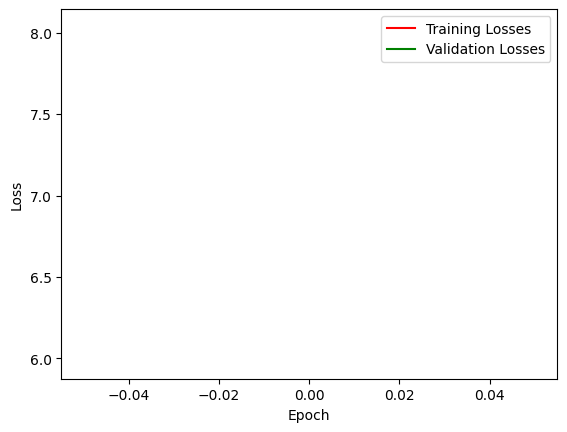

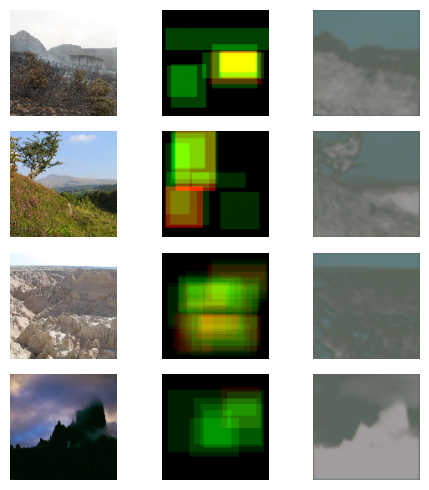

Starting Training for Using Instance Norm
Epoch [1/1], D: 0.5478, G: 92.1159,  Val Loss: 5.922578811645508 Train Loss: 7.288396835327148
Graph for Using Instance Norm


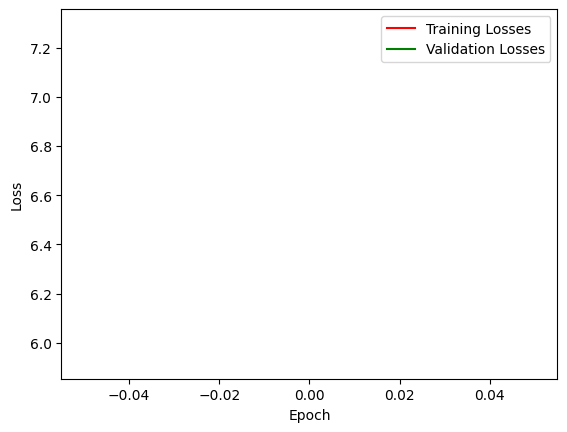

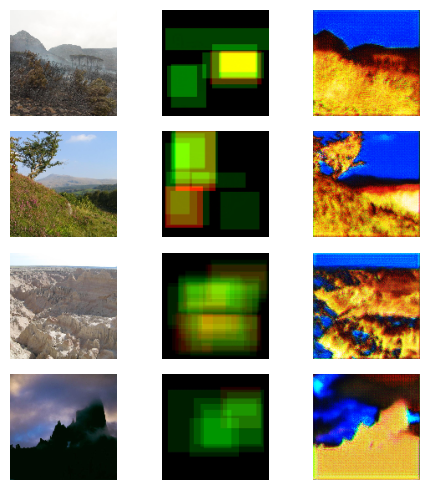

Starting Training for Using Adam
Epoch [1/1], D: 42.7424, G: 96.1490,  Val Loss: 6.604116916656494 Train Loss: 7.548462390899658
Graph for Using Adam


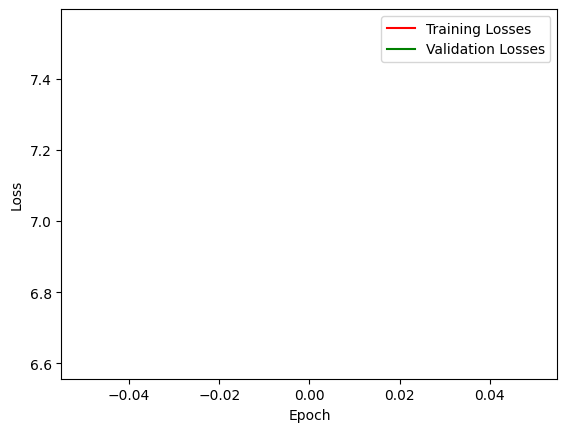

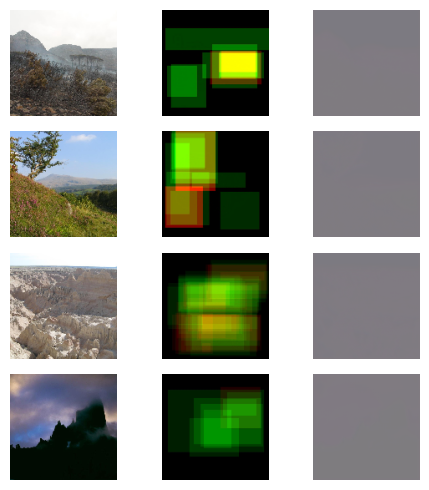

Starting Training for Using SGD
Epoch [1/1], D: 0.6113, G: 91.9893,  Val Loss: 5.957906723022461 Train Loss: 7.270301818847656
Graph for Using SGD


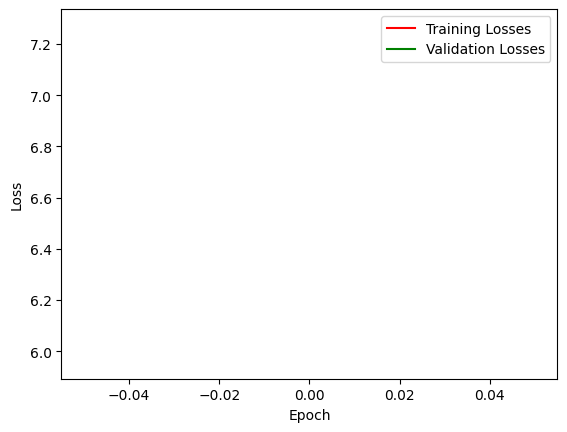

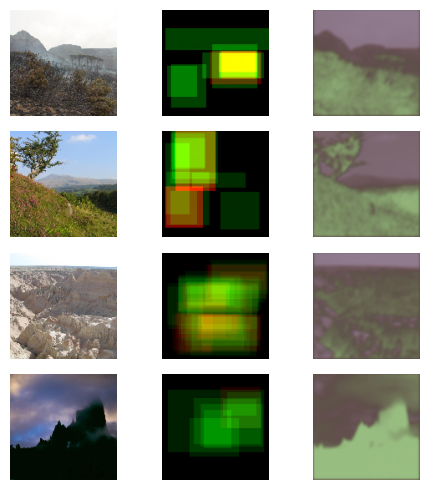

Starting Training for Using MSE Loss exclusively
Epoch [1/1], D: 0.6932, G: 116.3526,  Val Loss: 8.48987865447998 Train Loss: 9.205216407775879
Graph for Using MSE Loss exclusively


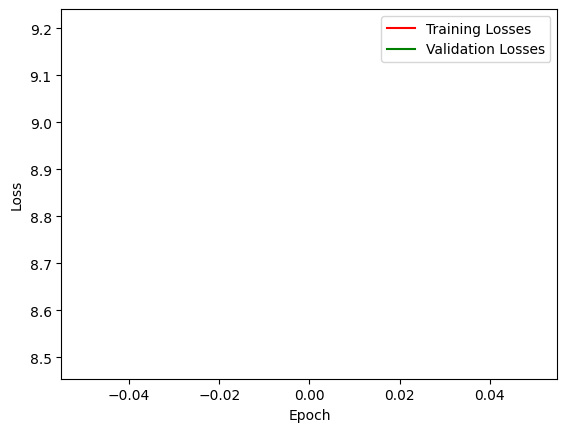

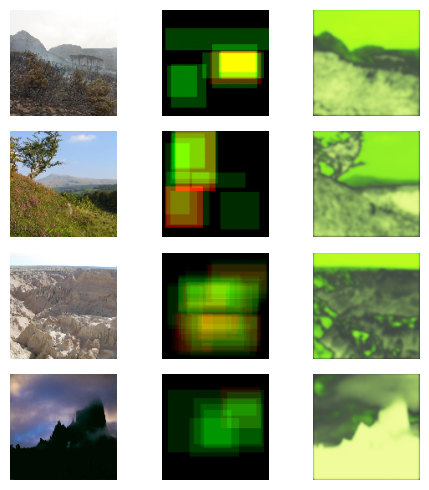

Starting Training for Using L1 Loss exclusively
Epoch [1/1], D: 0.6135, G: 96.8797,  Val Loss: 5.539028167724609 Train Loss: 7.670415878295898
Graph for Using L1 Loss exclusively


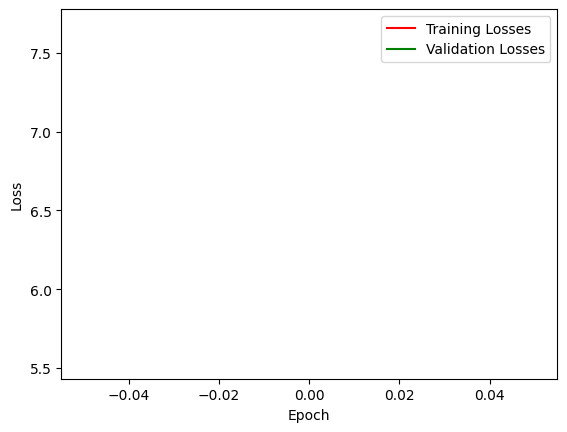

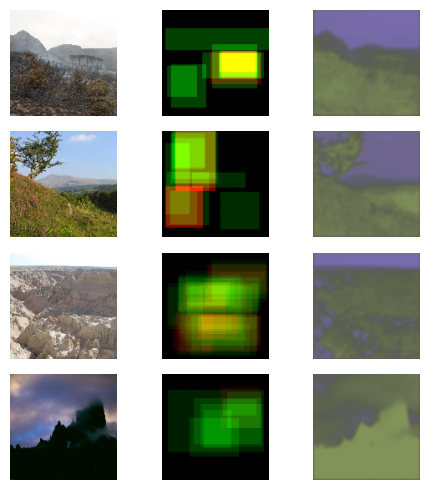

In [74]:
# Train with variations that we want to show

# Baseline
generator = Generator(norm_func = nn.BatchNorm2d)
discriminator = Discriminator(norm_func = nn.BatchNorm2d)
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Best Parameters and Hyperparameters"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Instance Norm
generator = Generator(norm_func = nn.InstanceNorm2d)
discriminator = Discriminator(norm_func = nn.InstanceNorm2d)
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Using Instance Norm"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Both using Adam
generator = Generator(norm_func = nn.BatchNorm2d)
discriminator = Discriminator(norm_func = nn.BatchNorm2d)
optim_g = torch.optim.Adam(discriminator.parameters())
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Using Adam"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Both using SGD
generator = Generator(norm_func = nn.BatchNorm2d)
discriminator = Discriminator(norm_func = nn.BatchNorm2d)
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.SGD(generator.parameters(), lr=0.01)
save_dir = "Using SGD"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
del generator, discriminator, optim_g, optim_d

# Using MSE Loss exclusively
generator = Generator(norm_func = nn.BatchNorm2d)
discriminator = Discriminator(norm_func = nn.BatchNorm2d)
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Using MSE Loss exclusively"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir, nn.MSELoss(), nn.MSELoss())
del generator, discriminator, optim_g, optim_d

# Using L1 Loss exclusively
generator = Generator(norm_func = nn.BatchNorm2d)
discriminator = Discriminator(norm_func = nn.BatchNorm2d)
optim_g = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_d = torch.optim.Adam(discriminator.parameters())
save_dir = "Using L1 Loss exclusively"
train_GAN(generator, discriminator,optim_g,optim_d,save_dir, nn.L1Loss(), nn.L1Loss())
del generator, discriminator, optim_g, optim_d